5
(60000, 28, 28)


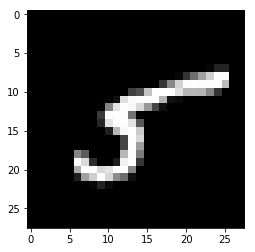

In [50]:
import numpy as np
import matplotlib.pyplot as plt

"""
读取MNIST数据
"""

def load_data():

    img_test_data = open('GANs_MNIST/t10k-images.idx3-ubyte')
    test_label = open('GANs_MNIST/t10k-labels.idx1-ubyte')
    img_train_data = open('GANs_MNIST/train-images.idx3-ubyte')
    train_label = open('GANs_MNIST/train-labels.idx1-ubyte')

    num_test = 10000
    num_train = 60000
    length = 28 * 28

    array_test_data = np.fromfile(img_test_data, dtype=np.uint8)
    array_test_label = np.fromfile(test_label, dtype=np.uint8)
    array_train_data = np.fromfile(img_train_data, dtype=np.uint8)
    array_train_label = np.fromfile(train_label, dtype=np.uint8)
    
#     t_imgs = np.transpose(array_test_data[16:].reshape(28, 28, 10000), (2, 0, 1))
#     t_labels = array_test_label[8:]
#     tr_imgs = np.transpose(array_train_data[16:].reshape(28, 28, 60000), (2, 0, 1))
#     tr_labels = array_train_label[8:]

    t_imgs = []
    t_labels = array_test_label[8:]
    tr_imgs = []
    tr_labels = array_train_label[8:]

    for i in range(num_test):
        t_imgs.append(array_test_data[16 + i * length : 16 + (i + 1) * length].reshape(28, 28))

    for i in range(num_train):
        tr_imgs.append(array_train_data[16 + i * length : 16 + (i + 1) * length].reshape(28, 28))
        
    tr_imgs = np.array(tr_imgs)
    t_imgs = np.array(t_imgs)
    
    return (tr_imgs, tr_labels), (t_imgs, t_labels)

(tr_i, tr_l), (t_i, t_l) = load_data()
print(tr_l[65])
plt.imshow(tr_i[65], cmap='gray')
print(tr_i.shape)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
import numpy as np
from PIL import Image
import argparse
import math


def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model


def discriminator_model():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(28, 28, 1))
            )
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model


def generator_containing_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model


def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image


def train(BATCH_SIZE):
    (X_train, y_train), (X_test, y_test) = load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train[:, :, :, None]
    X_test = X_test[:, :, :, None]
    # X_train = X_train.reshape((X_train.shape, 1) + X_train.shape[1:])
    d = discriminator_model()
    g = generator_model()
    d_on_g = generator_containing_discriminator(g, d)
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    for epoch in range(100):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(image.astype(np.uint8)).save(
                    str(epoch)+"_"+str(index)+".png")
            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = d.train_on_batch(X, y)
            print("batch %d d_loss : %f" % (index, d_loss))
            noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
            d.trainable = True
            print("batch %d g_loss : %f" % (index, g_loss))
            if index % 10 == 9:
                g.save_weights('generator', True)
                d.save_weights('discriminator', True)


def generate(BATCH_SIZE, nice=False):
    g = generator_model()
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    g.load_weights('generator')
    if nice:
        d = discriminator_model()
        d.compile(loss='binary_crossentropy', optimizer="SGD")
        d.load_weights('discriminator')
        noise = np.random.uniform(-1, 1, (BATCH_SIZE*20, 100))
        generated_images = g.predict(noise, verbose=1)
        d_pret = d.predict(generated_images, verbose=1)
        index = np.arange(0, BATCH_SIZE*20)
        index.resize((BATCH_SIZE*20, 1))
        pre_with_index = list(np.append(d_pret, index, axis=1))
        pre_with_index.sort(key=lambda x: x[0], reverse=True)
        nice_images = np.zeros((BATCH_SIZE,) + generated_images.shape[1:3], dtype=np.float32)
        nice_images = nice_images[:, :, :, None]
        for i in range(BATCH_SIZE):
            idx = int(pre_with_index[i][1])
            nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]
        image = combine_images(nice_images)
    else:
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        generated_images = g.predict(noise, verbose=1)
        image = combine_images(generated_images)
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save(
        "generated_image.png")


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--mode", type=str)
    parser.add_argument("--batch_size", type=int, default=128)
    parser.add_argument("--nice", dest="nice", action="store_true")
    parser.set_defaults(nice=False)
    args = parser.parse_args()
    return args

if __name__ == "__main__":
    args = get_args()
    if args.mode == "train":
        train(BATCH_SIZE=args.batch_size)
    elif args.mode == "generate":
        generate(BATCH_SIZE=args.batch_size, nice=args.nice)